In [1]:
import hydra
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
from omegaconf import OmegaConf
from jaxman.env.pick_and_delivery.env import JaxPandDEnv
from jaxman.utils import compute_agent_action
from jaxman.utils import compute_agent_action
from jaxman.planner.rl_planner.agent.dqn.dqn import create_dqn_agent
from jaxman.planner.rl_planner.agent.core import create_agent
from jaxman.planner.rl_planner.rollout.rollout import _build_rollout_episode
from flax.training import checkpoints
config = hydra.utils.instantiate(OmegaConf.load("../scripts/config/env/pick_and_delivery/continuous.yaml"))
model_config = hydra.utils.instantiate(OmegaConf.load("../scripts/config/model/sac.yaml"))
config.level=1
config.map_size=150
config.num_agents=5
config.num_items=5
config.dist_reward=0.05
config.is_discrete=False
config.is_decay_reward=False
config.is_biased_sample=True
config.use_hold_item_info=True
config.timeout=1
env = JaxPandDEnv(config)
key = jax.random.PRNGKey(0)

2023-03-28 09:31:42.321603: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asano/jaxman/.venv/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:
2023-03-28 09:31:42.351287: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-28 09:31:42.964786: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/asano/jaxman/.venv/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:
2023-03-28 09:31:42.964882: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library

In [21]:
observation_space = env.observation_space
action_space = env.action_space
key = jax.random.PRNGKey(0)
agent, key = create_agent(
    observation_space,
    action_space,
    model_config,
    key,
)
_rollout_fn = _build_rollout_episode(
    env.instance, agent.actor.apply_fn, evaluate=False, model_config=model_config
)

/home/asano/jaxman/.venv/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


In [22]:
carry = _rollout_fn(jax.random.PRNGKey(0), agent.actor.params, env.instance.obs, False)

In [29]:
actions = jnp.array([[1.0,1.0,0]])
obs, rew, info, done = env.step(actions)

In [2]:
obs = env.reset()
# print(env.task_info.item_starts)
is_item_loaded = jnp.expand_dims(jnp.arange(env.num_items) < env.num_agents, -1)
item_pos = env.task_info.item_starts + is_item_loaded * 1000
env.state = env.state._replace(load_item_id = jnp.arange(env.num_agents,), item_pos = item_pos)

[0.] [[0.43638533 0.4005066 ]]
[0.] [[0.4459705  0.39765626]]
[0.] [[0.45538077 0.39427295]]
[0.] [[0.46435305 0.38985732]]
[0.] [[0.47306365 0.38494554]]


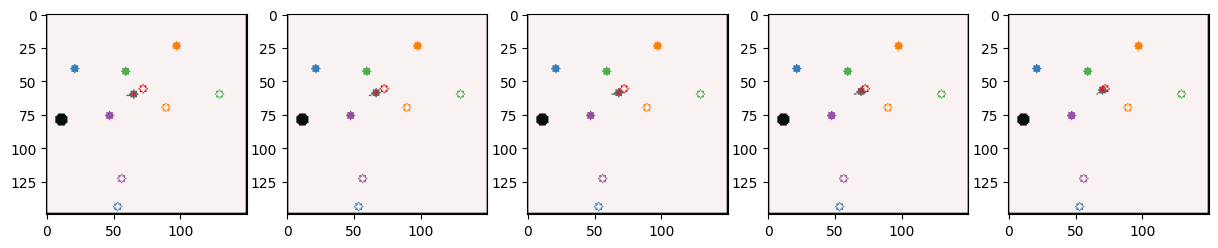

In [4]:
fig, axes = plt.subplots(1,5, figsize=(15,3))
for i in range(5):
    actions = jnp.concatenate((obs.planner_act, jnp.array([[-1]])),axis=1)
    obs, rew, done, info = env.step(actions)
    axes[i].imshow(env.render())
    print(rew, env.state.agent_state.pos)

[0.01887928]
[[0.42951068 0.4095044 ]
 [0.14173023 0.27933216]
 [0.3961167  0.29305947]
 [0.3162247  0.50957674]
 [0.6506388  0.16458122]]


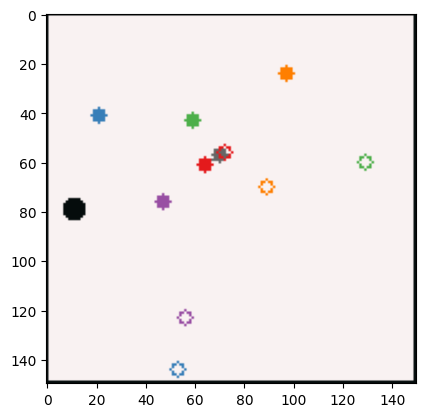

In [5]:
obs, rew, done, info = env.step(jnp.array([[0,0,1]]))
print(rew)
print(env.task_info.item_starts)
plt.imshow(env.render())

In [2]:
import jax
from jaxman.planner.rl_planner.agent.model.continuous_model import PandDDoubleCritic

In [4]:
obs = env.obs.split_observation()
actor_fn = PandDDoubleCritic(10, 10)
actions = jnp.array([[1,1,1],[1,1,1],[1,1,1],[1,1,1],[1,1,1],])
params = actor_fn.init(jax.random.PRNGKey(0), obs, actions)["params"]

[[[-0.4651546  -0.08168128]
  [-0.4775101  -0.15263213]
  [-0.47613388 -0.1872753 ]
  [-0.46765012 -0.20204313]
  [-0.4665933  -0.10841294]]

 [[ 0.9565174  -1.159926  ]
  [ 0.89871734 -1.114136  ]
  [ 0.96520716 -1.3296021 ]
  [ 0.9004991  -1.2359104 ]
  [ 0.96909624 -1.1668161 ]]]
[[[-0.01390487]
  [ 0.00349348]
  [ 0.02184999]
  [ 0.02847132]
  [-0.00211426]]

 [[-0.41449854]
  [-0.42842752]
  [-0.3669318 ]
  [-0.4109067 ]
  [-0.4167949 ]]]


/home/asano/jaxman/.venv/lib/python3.9/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


In [6]:
dis_q1, dis_q2, cont_q1, cont_q2=actor_fn.apply({"params":params}, obs, actions)

[[[-0.4651546  -0.08168128]
  [-0.4775101  -0.15263213]
  [-0.47613388 -0.1872753 ]
  [-0.46765012 -0.20204313]
  [-0.4665933  -0.10841294]]

 [[ 0.9565174  -1.159926  ]
  [ 0.89871734 -1.114136  ]
  [ 0.96520716 -1.3296021 ]
  [ 0.9004991  -1.2359104 ]
  [ 0.96909624 -1.1668161 ]]]
[[[-0.01390487]
  [ 0.00349348]
  [ 0.02184999]
  [ 0.02847132]
  [-0.00211426]]

 [[-0.41449854]
  [-0.42842752]
  [-0.3669318 ]
  [-0.4109067 ]
  [-0.4167949 ]]]
